# Demo Notebook
This notebook:
1. Loads Algonauts 2023 training fMRI (lh+rh concatenated)
2. Reconstructs the stimulus image paths
3. Extracts ResNet50 avgpool features (caching to data/features/)
4. Fits a Ridge(α=100) encoding model from features → fMRI
5. Computes voxel-wise R² on held-out test samples
6. Prints summary statistics and plots an R² histogram.

## Imports

In [1]:
import os
import numpy as np

import algonauts_data_loading as alg
from feature_extraction import extract_resnet_avgpool_features
from model_fitting import fit_ridge_encoding_model
from evaluation import voxelwise_r2, summarize_r2
from visualization import plot_r2_histogram

## Choose Subject

In [2]:
# List available training subjects
subjects = alg.list_train_subjects()
print("Available subjects:")
for s in subjects:
    print("  ", s)

# Choose subject (edit this if you want a different one)
subject = "subj01-009"
print("\nUsing subject:", subject)


Available subjects:
   subj01-009
   subj02-002
   subj03-006
   subj04-005
   subj05-001
   subj06-003
   subj07-007
   subj08-004

Using subject: subj01-009


## Load Training Images

In [3]:
# Load training fMRI and associated NSD image IDs
img_ids_train, fmri_train = alg.load_train_subject_roi(subject)

print("fmri_train shape:", fmri_train.shape)    # (n_samples, n_voxels)
print("First 5 image IDs:", img_ids_train[:5])

# Reconstruct image paths from the Algonauts folder structure
subj_root = os.path.join(alg.TRAIN_DIR, subject)

inner_dirs = [
    d for d in os.listdir(subj_root)
    if os.path.isdir(os.path.join(subj_root, d))
]
if not inner_dirs:
    raise RuntimeError(f"No inner subject folder found inside {subj_root}.")
inner_subj = inner_dirs[0]

img_dir = os.path.join(
    subj_root,
    inner_subj,
    "training_split",
    "training_images",
)

if not os.path.isdir(img_dir):
    raise FileNotFoundError(f"Could not find training_images at: {img_dir}")

# Sorted list of image paths – should align with the order used in load_train_subject_roi
train_image_paths = sorted(
    os.path.join(img_dir, f)
    for f in os.listdir(img_dir)
    if f.lower().endswith(".png")
)

print("Number of training images:", len(train_image_paths))

if len(train_image_paths) != fmri_train.shape[0]:
    print("WARNING: number of images != number of fMRI trials")
    print("  images:", len(train_image_paths))
    print("  fmri rows:", fmri_train.shape[0])


Subject root: /Users/leoa.antonio/neuroai-model-brain-mapping/encoding_models/data/train_data/subj01-009
Using inner subject folder: /Users/leoa.antonio/neuroai-model-brain-mapping/encoding_models/data/train_data/subj01-009/subj01
Loaded hemisphere fMRI:
  LH shape: (9841, 19004)
  RH shape: (9841, 20544)

Loaded arrays:
  img_ids shape: (9841,)
  fmri shape: (9841, 39548)
fmri_train shape: (9841, 39548)
First 5 image IDs: [13 27 71 85 88]
Number of training images: 9841


## Extract ResNet50 Features

In [4]:
# Directory for cached features
features_dir = os.path.join(os.path.dirname(alg.TRAIN_DIR), "features")
os.makedirs(features_dir, exist_ok=True)

feat_path = os.path.join(features_dir, f"{subject}_resnet50_avgpool.npy")
print("Feature cache path:", feat_path)

if os.path.exists(feat_path):
    print("\nLoading cached features...")
    train_features = np.load(feat_path)
else:
    print("\nExtracting ResNet50 avgpool features (this may take a while)...")
    train_features = extract_resnet_avgpool_features(train_image_paths)
    np.save(feat_path, train_features)
    print("Saved features to:", feat_path)

print("train_features shape:", train_features.shape)  # (n_samples, 2048)


Feature cache path: /Users/leoa.antonio/neuroai-model-brain-mapping/encoding_models/data/features/subj01-009_resnet50_avgpool.npy

Loading cached features...
train_features shape: (9841, 2048)


## Fit Ridge Encoding Models

In [5]:
alpha = 100.0

print(
    f"Fitting Ridge encoding model for subject {subject} "
    f"(features: {train_features.shape}, voxels: {fmri_train.shape[1]}, alpha={alpha})"
)

result = fit_ridge_encoding_model(
    X=train_features,
    Y=fmri_train,
    alpha=alpha,
    test_size=0.2,
    random_state=0,
    standardize=True,
)

# Extract held-out test ground truth
y_test = fmri_train[result.test_idx]
y_pred_test = result.y_pred_test

print("\nShapes for evaluation:")
print("  y_test     :", y_test.shape)
print("  y_pred_test:", y_pred_test.shape)


Fitting Ridge encoding model for subject subj01-009 (features: (9841, 2048), voxels: 39548, alpha=100.0)
[model_fitting] X shape: (9841, 2048)
[model_fitting] Y shape: (9841, 39548)
[model_fitting] Train samples: 7872
[model_fitting] Test samples : 1969
[model_fitting] Standardized features with StandardScaler.
[model_fitting] Fitting Ridge(alpha=100.0) on full voxel matrix...
[model_fitting] Finished training.
[model_fitting] Finished test-set prediction.
[model_fitting] Y_pred_test shape: (1969, 39548)

Shapes for evaluation:
  y_test     : (1969, 39548)
  y_pred_test: (1969, 39548)


## Compute $R^2$

In [6]:
r2 = voxelwise_r2(y_test, y_pred_test)

_ = summarize_r2(r2, subject=subject)



Voxel-wise R² summary (subj01-009):
mean R²:   -0.0877
median R²: -0.1198
% R² > 0:  26.3%


## Histogram

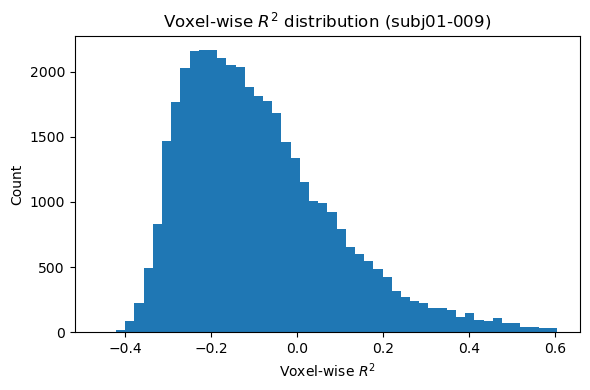

In [7]:
plot_r2_histogram(r2, subject=subject)